In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import matplotlib.dates as mdates

In [4]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

In [5]:
from src import data,viz

In [6]:
import os

In [7]:
# The conversion to `pd.Categorical` fails spectacularly, so we will do without it.
df_cosmo_de = pd.read_spss(f"{data.data_root}/external/COSMO/INSERM.sav", convert_categoricals=False) 

cosmo_de_dates = [
    '2020-03-04',
    '2020-03-11',
    '2020-03-18',
    '2020-03-25',
    '2020-04-01',
    '2020-04-08',
    '2020-04-15',
    '2020-04-22',
    '2020-04-29',
]
df_aff = df_cosmo_de.filter(regex='TIME|^AFF_',axis=1).dropna(axis=1)
df_aff['TIME'] = pd.to_datetime(
    df_aff.replace(
        {'TIME':dict(zip(range(1,len(cosmo_de_dates)+1),cosmo_de_dates))}
    )['TIME']
).astype('datetime64[D]')
df_aff = df_aff.groupby('TIME').mean()

In [8]:
import scipy.io as sio
import datetime

In [9]:
dkmat = sio.loadmat(f"{data.data_root}/external/COSMO_dk/COSMO_DK_crossSectional.mat")
colnames = [name[0] for name in dkmat["COSMO_DK_varnames"].squeeze()]
cosmo_dk_dates = [
    '2020-03-25',
    '2020-04-01',
    '2020-04-08',
    '2020-04-15',
    '2020-04-22',
    '2020-04-29',
    '2020-05-06',
    '2020-05-13',
]
df_cosmo_dk = pd.DataFrame(data=dkmat["COSMO_DK"], columns=colnames)
df_aff_dk = df_cosmo_dk.filter(regex='wave|^AFF_',axis=1)

df_aff_dk['wave'] = pd.to_datetime(
    df_aff_dk.replace(
        {'wave':dict(zip(range(13,len(cosmo_dk_dates)+13),cosmo_dk_dates))}
    )['wave']
).astype('datetime64[D]')
df_aff_dk = df_aff_dk.groupby('wave').mean()

/home/izaak/local_repos/glyptodon/CovidH_TNG/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


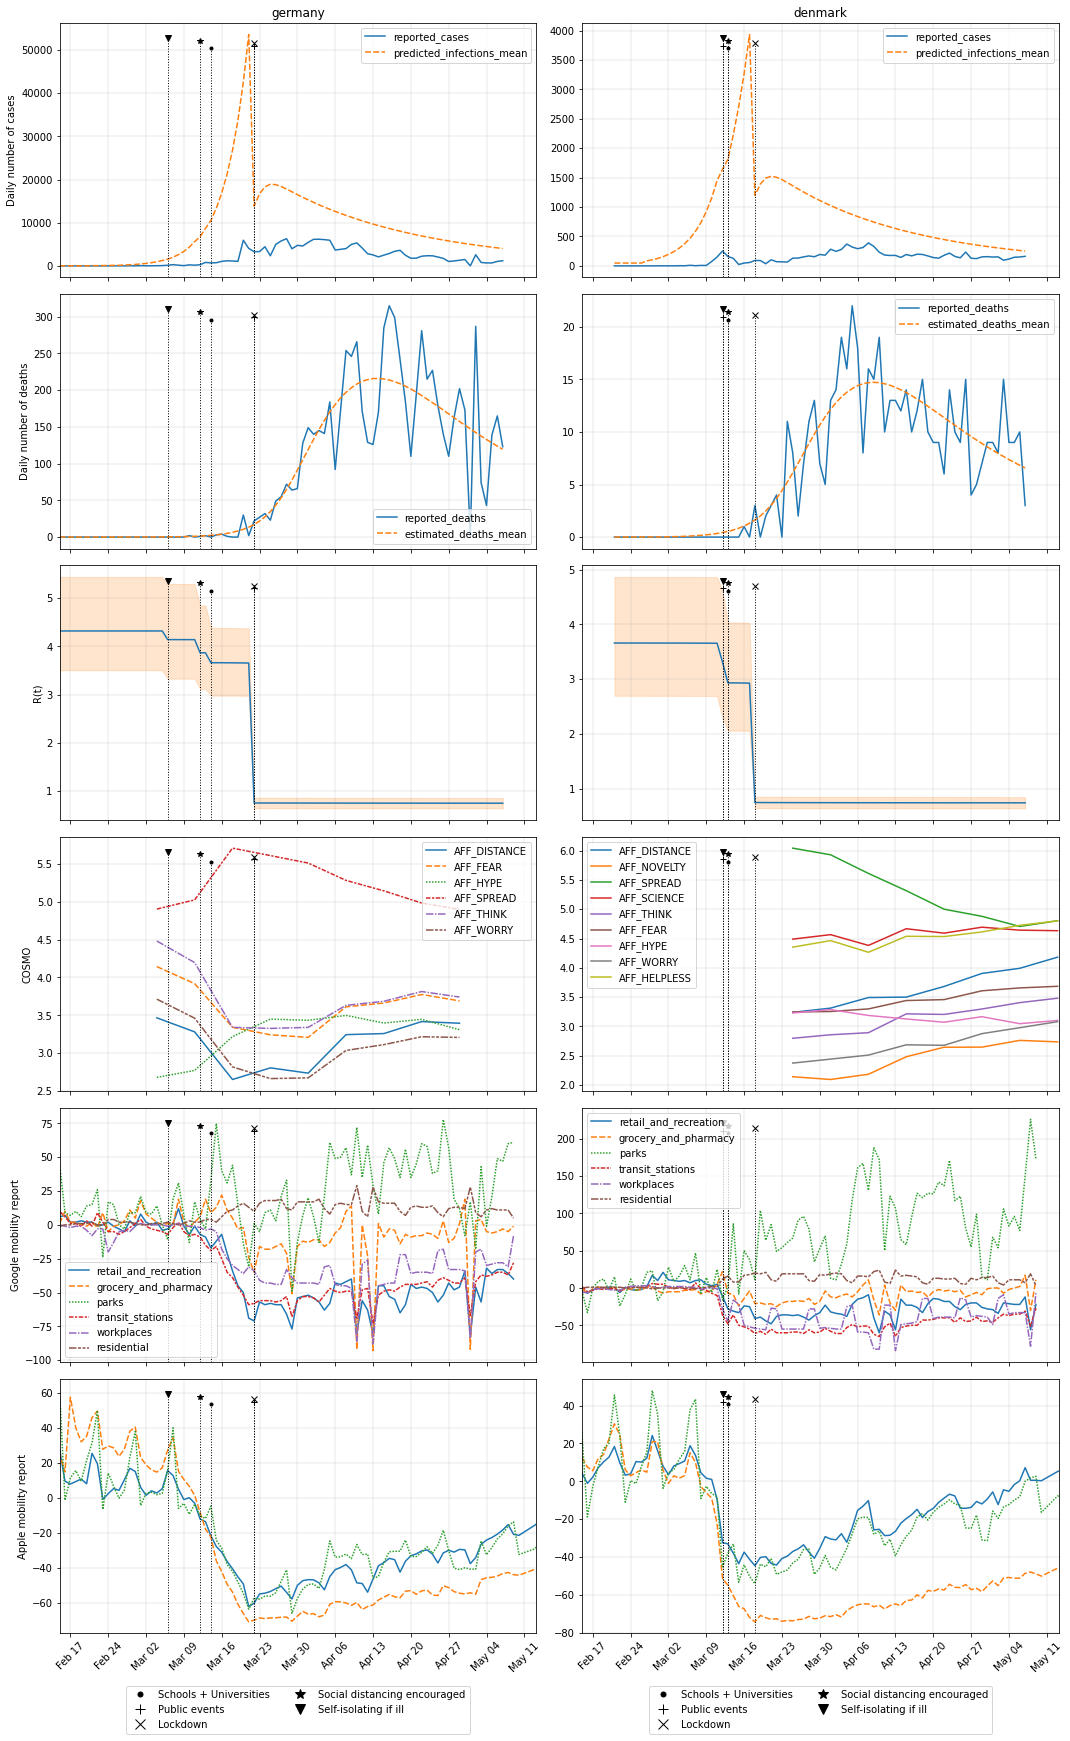

In [24]:
start_date=datetime.date(2020, 2, 15)
nrows=6
countries=['germany', 'denmark']
ncols=len(countries)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,nrows*4), sharex=True)

for i, country in enumerate(countries):
    df = data.load_imperial_college_results(country)
    a = 0

    ax = axs[a,i]
    a+=1
    sns.lineplot(
        data=df[ [ 'reported_cases', 'predicted_infections_mean' ] ],
        ax=ax
    )
    ax.fill_between(
        df.loc[df.country == country].index.values,
        df.loc[df.country == country].predicted_infections_lower_CI_95, 
        df.loc[df.country == country].predicted_infections_higher_CI_95, 
        color=sns.color_palette()[1],
        alpha=0.2
    )
    if i==0:
        ax.set_ylabel('Daily number of cases')
    ax.set_title(f'{country}')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)


    
    ax=axs[a,i]
    a+=1
    sns.lineplot(
        data=df[ ['reported_deaths', 'estimated_deaths_mean']],
        ax=ax
    )
    ax.fill_between(
        df.loc[df.country == country].index.values,
        df.loc[df.country == country].estimated_deaths_lower_CI_95, 
        df.loc[df.country == country].estimated_deaths_higher_CI_95,
        color=sns.color_palette()[1],
        alpha=0.2
    )
    if i==0:
        ax.set_ylabel('Daily number of deaths')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)

    ax=axs[a,i]
    a+=1
    sns.lineplot(
        data=df['mean_time_varying_reproduction_number_R(t)'],
        ax=ax
    )
    ax.fill_between(
        df.index.values,
        df['time_varying_reproduction_number_R(t)_lower_CI_95'],
        df['time_varying_reproduction_number_R(t)_higher_CI_95'],
        color=sns.color_palette()[1],
        alpha=0.2
    )
    if i==0:
        ax.set_ylabel(f'R(t)')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)
    
    ax=axs[a,i]
    a+=1
    if country == 'germany':
        sns.lineplot(
            data=df_aff,
            ax=ax
        )
    if country == 'denmark':
        sns.lineplot(
            data=df_aff_dk,
            dashes=False,
            ax=ax
        )
    if i==0:
        ax.set_ylabel('COSMO')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)
    
    ax=axs[a,i]
    a+=1
    df = data.load_mobility(country, 'google')
    sns.lineplot(
        data=df.rename(
            axis='columns',
            mapper={
                'retail_and_recreation_percent_change_from_baseline':'retail_and_recreation',
                'grocery_and_pharmacy_percent_change_from_baseline':'grocery_and_pharmacy',
                'parks_percent_change_from_baseline':'parks',
                'transit_stations_percent_change_from_baseline':'transit_stations',
                'workplaces_percent_change_from_baseline':'workplaces',
                'residential_percent_change_from_baseline':'residential'
            }
                
        ),
        ax=ax
    )
    if i==0:
        ax.set_ylabel('Google mobility report')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country)
    ax.set_xlim(left=start_date)

    ax=axs[a,i]
    a+=1
    df = data.load_mobility(country, 'apple')
    sns.lineplot(
        data=df-100,
        ax=ax
    )
    if i==0:
        ax.set_ylabel('Apple mobility report')
    ax.grid(color='#999999', linewidth=0.2)
    viz.annotate_interventions(ax,country,legend=True)
    ax.set_xlim(left=start_date)

    
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_tick_params(rotation=45)
    ax.set_xlabel('')
fig.tight_layout()